[View in Colaboratory](https://colab.research.google.com/github/mohanrajmit/Face-Recognition-data/blob/master/Face_Recognition.ipynb)

In [3]:
!pip install cmake

!pip install dlib

  Using cached https://files.pythonhosted.org/packages/35/8d/e4ddf60452e2fb1ce3164f774e68968b3f110f1cb4cd353235d56875799e/dlib-19.16.0.tar.gz
  Running setup.py bdist_wheel for dlib ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/ce/f9/bc/1c51cd0b40a2b5dfd46ab79a73832b41e7c3aa918a508154f0
Successfully built dlib


In [4]:
!pip3 install face_recognition

    100% |████████████████████████████████| 100.2MB 318kB/s 
    100% |████████████████████████████████| 81kB 23.0MB/s 
  Running setup.py bdist_wheel for face-recognition-models ... - \ | / - \ | done
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [5]:
!git clone https://github.com/ageitgey/face_recognition.git

Cloning into 'face_recognition'...
remote: Enumerating objects: 642, done.
remote: Total 642 (delta 0), reused 0 (delta 0), pack-reused 642
Receiving objects: 100% (642/642), 101.36 MiB | 31.42 MiB/s, done.
Resolving deltas: 100% (355/355), done.


In [9]:
!ls

face_recognition  sample_data


In [7]:
!pip3 install scikit-learn

In [0]:
import math
from sklearn import neighbors
import os
import os.path
import pickle
from PIL import Image, ImageDraw
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder

ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}

In [0]:
def train(train_dir, model_save_path=None, n_neighbors=None, knn_algo='ball_tree', verbose=False):
    """
    Trains a k-nearest neighbors classifier for face recognition.
    :param train_dir: directory that contains a sub-directory for each known person, with its name.
     (View in source code to see train_dir example tree structure)
     Structure:
        <train_dir>/
        ├── <person1>/
        │   ├── <somename1>.jpeg
        │   ├── <somename2>.jpeg
        │   ├── ...
        ├── <person2>/
        │   ├── <somename1>.jpeg
        │   └── <somename2>.jpeg
        └── ...
    :param model_save_path: (optional) path to save model on disk
    :param n_neighbors: (optional) number of neighbors to weigh in classification. Chosen automatically if not specified
    :param knn_algo: (optional) underlying data structure to support knn.default is ball_tree
    :param verbose: verbosity of training
    :return: returns knn classifier that was trained on the given data.
    """
    X = []
    y = []

    # Loop through each person in the training set
    for class_dir in os.listdir(train_dir):
        if not os.path.isdir(os.path.join(train_dir, class_dir)):
            continue

        # Loop through each training image for the current person
        for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
            image = face_recognition.load_image_file(img_path)
            face_bounding_boxes = face_recognition.face_locations(image)

            if len(face_bounding_boxes) != 1:
                # If there are no people (or too many people) in a training image, skip the image.
                if verbose:
                    print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))
            else:
                # Add face encoding for current image to the training set
                X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                y.append(class_dir)

    # Determine how many neighbors to use for weighting in the KNN classifier
    if n_neighbors is None:
        n_neighbors = int(round(math.sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically:", n_neighbors)

    # Create and train the KNN classifier
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    # Save the trained KNN classifier
    if model_save_path is not None:
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)

    return knn_clf


In [0]:
def predict(X_img_path, knn_clf=None, model_path=None, distance_threshold=0.6):
    """
    Recognizes faces in given image using a trained KNN classifier
    :param X_img_path: path to image to be recognized
    :param knn_clf: (optional) a knn classifier object. if not specified, model_save_path must be specified.
    :param model_path: (optional) path to a pickled knn classifier. if not specified, model_save_path must be knn_clf.
    :param distance_threshold: (optional) distance threshold for face classification. the larger it is, the more chance
           of mis-classifying an unknown person as a known one.
    :return: a list of names and face locations for the recognized faces in the image: [(name, bounding box), ...].
        For faces of unrecognized persons, the name 'unknown' will be returned.
    """
    if not os.path.isfile(X_img_path) or os.path.splitext(X_img_path)[1][1:] not in ALLOWED_EXTENSIONS:
        raise Exception("Invalid image path: {}".format(X_img_path))

    if knn_clf is None and model_path is None:
        raise Exception("Must supply knn classifier either thourgh knn_clf or model_path")

    # Load a trained KNN model (if one was passed in)
    if knn_clf is None:
        with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)

    # Load image file and find face locations
    X_img = face_recognition.load_image_file(X_img_path)
    X_face_locations = face_recognition.face_locations(X_img)

    # If no faces are found in the image, return an empty result.
    if len(X_face_locations) == 0:
        return []

    # Find encodings for faces in the test iamge
    faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)

    # Use the KNN model to find the best matches for the test face
    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)
    are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(X_face_locations))]

    # Predict classes and remove classifications that aren't within the threshold
    return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)]




In [0]:
def show_prediction_labels_on_image(img_path, predictions,i):
  pil_image = Image.open(img_path).convert("RGB")
  import matplotlib.pyplot as plt
  
  draw = ImageDraw.Draw(pil_image)
  i=0
  for name, (top, right, bottom, left) in predictions:
    # Draw a box around the face using the Pillow module
    draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))
    # There's a bug in Pillow where it blows up with non-UTF-8 text
    # when using the default bitmap font
    name = name.encode("UTF-8")
    # Draw a label with a name below the face
    text_width, text_height = draw.textsize(name)
    draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
    draw.text((left + 6, bottom - text_height - 5), name, fill=(255, 255, 255, 255))
    # Remove the drawing library from memory as per the Pillow docs
    #axes[i].imshow(draw,cmap=plt.cm.Greys)
    #plt.imshow(im.reshape(im.shape[0], im.shape[1]), cmap=plt.cm.Greys)
    i+=1
    #plt.imshow(draw)
  #plt.show()
  del draw
  # Display the resulting image
  #plt.imshow(pil_image)
  #pil_image.show()
  na="face_recognition"+str(i)+".jpg"
  print(na)
  pil_image.save(str(na))

In [55]:
print("Training KNN classifier...")
i=0
classifier = train("face_recognition/examples/knn_examples/train", model_save_path="trained_knn_model.clf", n_neighbors=2)
print("Training complete!")
# STEP 2: Using the trained classifier, make predictions for unknown images
for image_file in os.listdir("face_recognition/examples/knn_examples/test"):
  full_file_path = os.path.join("face_recognition/examples/knn_examples/test", image_file)
  print("Looking for faces in {}".format(image_file))
  # Find all people in the image using a trained classifier model
  # Note: You can pass in either a classifier file name or a classifier model instance
  predictions = predict(full_file_path, model_path="trained_knn_model.clf")
  # Print results on the console
  for name, (top, right, bottom, left) in predictions:
    print("- Found {} at ({}, {})".format(name, left, top))
    # Display results overlaid on an image
    show_prediction_labels_on_image(os.path.join("face_recognition/examples/knn_examples/test", image_file), predictions,i)
    i=i+1

Training KNN classifier...
Training complete!
Looking for faces in obama1.jpg
- Found obama at (546, 204)
face_recognition1.jpg
Looking for faces in kit_with_rose.jpg
- Found rose_leslie at (79, 130)
face_recognition2.jpg
- Found kit_harington at (247, 92)
face_recognition2.jpg
Looking for faces in obama_and_biden.jpg
- Found biden at (737, 449)
face_recognition3.jpg
- Found obama at (1133, 390)
face_recognition3.jpg
- Found unknown at (1594, 1062)
face_recognition3.jpg
Looking for faces in alex_lacamoire1.jpg
- Found alex_lacamoire at (633, 206)
face_recognition1.jpg
Looking for faces in johnsnow_test1.jpg
- Found kit_harington at (262, 180)
face_recognition1.jpg


In [56]:
!ls

face_recognition       face_recognition3.jpg  trained_knn_model.clf
face_recognition1.jpg  face_Recognition.jpg
face_recognition2.jpg  sample_data


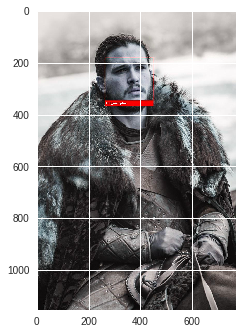

In [46]:
import cv2
import matplotlib.pyplot as plt

img=cv2.imread("face_Recognition.jpg")

plt.imshow(img)